In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader

from torchmetrics.classification import BinaryAccuracy, MultilabelAccuracy

plt.style.use("dark_background")

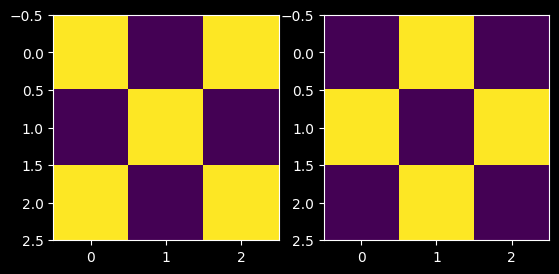

In [2]:
cross = np.array([
    [1, 0, 1],
    [0, 1, 0],
    [1, 0, 1],
])
plus = np.array([
    [0, 1, 0],
    [1, 0, 1],
    [0, 1, 0],
])

dimension = height, width = plus.shape

_, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

ax1.imshow(cross)
ax2.imshow(plus)

In [3]:
def fill_boards(blank_shape, piece):
    blank = np.zeros(blank_shape)
    height, width = piece.shape

    fills = []
    for i in range(0, blank.shape[0], height):
        for j in range(0, blank.shape[1], width):
            board = blank.copy()
            board[i:i + height, j:j + width] = piece
            fills.append(board)
    
    return np.array(fills)

In [4]:
def plot_pieces(boards):
    halfed = np.sqrt(boards.shape[0])
    halfed = int(halfed)
    _, axes = plt.subplots(nrows=halfed, ncols=halfed)
    
    for board, ax in zip(boards, axes.flat):
        ax.imshow(board)

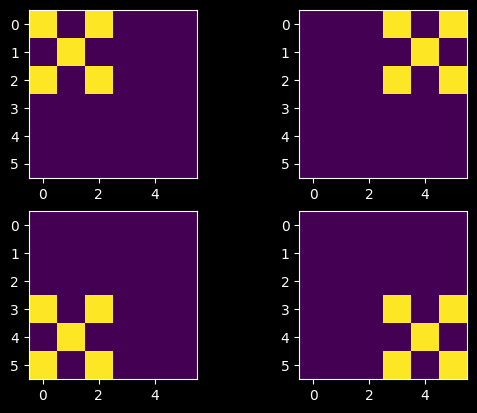

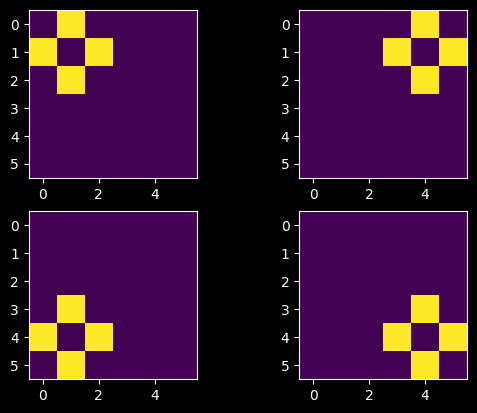

In [5]:
cross_boards = fill_boards((6, 6), cross)
plus_boards = fill_boards((6, 6), plus)

plot_pieces(cross_boards)
plot_pieces(plus_boards)

In [6]:
crosses = torch.tensor(cross_boards, dtype=torch.float).unsqueeze(1)
pluses = torch.tensor(plus_boards, dtype=torch.float).unsqueeze(1)

cross_labels = torch.tensor([[1, 0]] * crosses.shape[0], dtype=torch.float)
plus_labels = torch.tensor([[0, 1]] * pluses.shape[0], dtype=torch.float)

data_images = torch.concat([
    crosses,
    pluses,
])

data_labels = torch.concat([
    cross_labels,
    plus_labels,
])

dataset = TensorDataset(data_images, data_labels)

In [7]:
crosses.shape

torch.Size([4, 1, 6, 6])

In [37]:
class SymbolClassifier(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        self.channel = input_shape[0]
        self.height = input_shape[1]
        self.width = input_shape[2]
        
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.channel * self.height * self.width, 2),
            nn.Sigmoid(),
        )
    
    def forward(self, X):
        return self.model(X)
    
    def predict(self, X):
        with torch.no_grad():
            return self.model(X).detach()

Epoch 1/200: loss = 0.6594
Epoch 2/200: loss = 0.5958
Epoch 3/200: loss = 0.5409
Epoch 4/200: loss = 0.4933
Epoch 5/200: loss = 0.4520
Epoch 6/200: loss = 0.4160
Epoch 7/200: loss = 0.3844
Epoch 8/200: loss = 0.3566
Epoch 9/200: loss = 0.3320
Epoch 10/200: loss = 0.3102
Epoch 11/200: loss = 0.2907
Epoch 12/200: loss = 0.2733
Epoch 13/200: loss = 0.2576
Epoch 14/200: loss = 0.2435
Epoch 15/200: loss = 0.2307
Epoch 16/200: loss = 0.2190
Epoch 17/200: loss = 0.2084
Epoch 18/200: loss = 0.1987
Epoch 19/200: loss = 0.1897
Epoch 20/200: loss = 0.1815
Epoch 21/200: loss = 0.1739
Epoch 22/200: loss = 0.1669
Epoch 23/200: loss = 0.1604
Epoch 24/200: loss = 0.1543
Epoch 25/200: loss = 0.1487
Epoch 26/200: loss = 0.1434
Epoch 27/200: loss = 0.1385
Epoch 28/200: loss = 0.1339
Epoch 29/200: loss = 0.1295
Epoch 30/200: loss = 0.1255
Epoch 31/200: loss = 0.1216
Epoch 32/200: loss = 0.1180
Epoch 33/200: loss = 0.1146
Epoch 34/200: loss = 0.1113
Epoch 35/200: loss = 0.1082
Epoch 36/200: loss = 0.1053
E

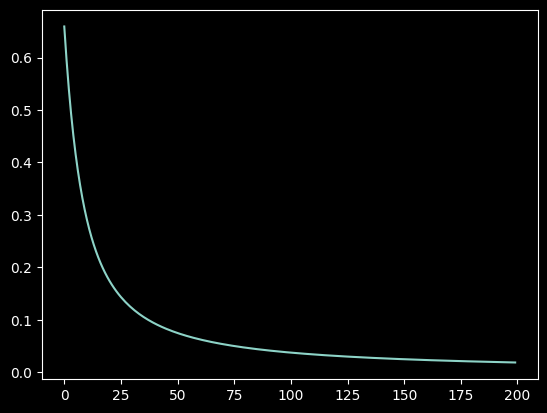

In [38]:
symbol_classifier = SymbolClassifier(crosses.shape[1:])

lr = 1
epochs = 200

criterion = nn.BCELoss()
optimizer = optim.SGD(symbol_classifier.parameters(), lr=lr)
data_loader = DataLoader(dataset, batch_size=len(dataset))

losses = []
for epoch in range(1, epochs + 1):
    total_loss = 0
    for image, label in data_loader:
        yhat = symbol_classifier.forward(image)
        loss = criterion(yhat, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    total_loss /= len(data_loader)
    losses.append(total_loss)
    print(f"Epoch {epoch}/{epochs}: loss = {total_loss:,.4f}")


plt.plot(losses)

In [40]:
get_accuracy = MultilabelAccuracy(2)
y_pred = symbol_classifier.predict(data_images)
accuracy = get_accuracy(y_pred, data_labels)

print(f"Loss: {losses[-1]:.4f}")
print(f"Accuracy: {accuracy:.2%}")

Loss: 0.0186
Accuracy: 100.00%


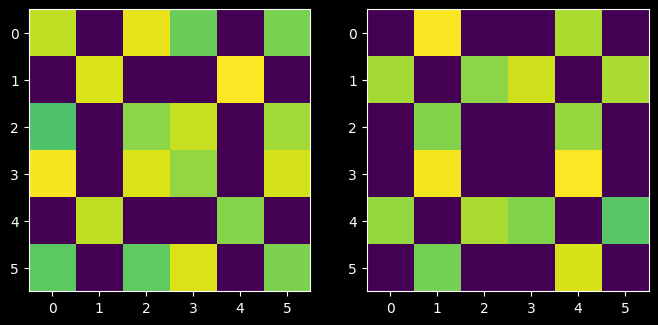

In [41]:
layer1 = symbol_classifier.state_dict()['model.1.weight'].relu()

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(8)
fig.set_figheight(16)

for neuron_weights, ax in zip(layer1, axes.flat):
    weight_image = neuron_weights.reshape(6, 6)
    ax.imshow(weight_image)